In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


import os
from dotenv import load_dotenv
load_dotenv()


from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [28]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant", streaming=True)

In [4]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

In [5]:
tools=[tool]
llm_with_tool=llm.bind_tools(tools)

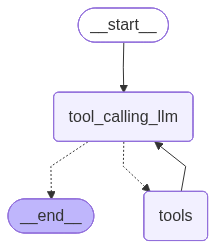

In [6]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
response=graph.invoke({"messages":"Hello my name is Om"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Om
================================== Ai Message ==================================

Nice to meet you Om. How can I assist you today?


In [ ]:
response=graph.invoke({"messages":"Hey, do u remember mee?"})
for m in response['messages']:
    m.pretty_print()
    
# No memory in this graph.

================================ Human Message =================================

Hey, do u remember mee?
================================== Ai Message ==================================

No, I don't think we have had any prior conversations. I'm a large language model, I don't have personal memories or the ability to retain information about individual users. Each time you interact with me, it's a new conversation. How can I help you today?


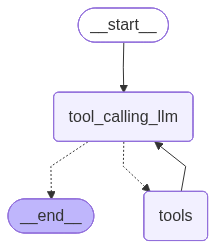

In [10]:
# same graph again:

## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()   ## just this changes

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)   ## added here

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Om"},config=config)

response['messages'][-1].content

## what this config does it, with all unique thread id, each thread id has its own conversation history and it remember is 
# when we pass thread id from config

"It seems like you're introducing yourself again. Welcome, Om. What's on your mind?"

In [ ]:
graph.get_state(config)

## u can see what that specific thread id has in its conversation history.

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='fae06ed8-f346-4ab5-bacd-1fec8fee7430'), AIMessage(content='Hello Krish.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 1687, 'total_tokens': 1691, 'completion_time': 0.012342228, 'completion_tokens_details': None, 'prompt_time': 0.14258732, 'prompt_tokens_details': None, 'queue_time': 0.04758261, 'total_time': 0.154929548}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c846a-53e2-7a33-a9d8-156592fc64c9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1687, 'output_tokens': 4, 'total_tokens': 1691}), HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='e3a90018-c4a1-4ae8-87c7-16b2fff9a579'), AIMessage(con

In [17]:
config={"configurable":{"thread_id":"3"}}   # new thread id

response=graph.invoke({"messages":"Hey, do u remember me?"},config=config)

response['messages'][-1].content

"No, I don't remember you. I'm a large language model, I don't have personal memories or the ability to recall individual users. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations."

## Streaming

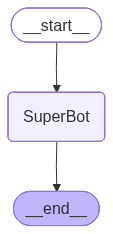

In [ ]:
## Creating new graph
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)

## Edges
graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [24]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi, My name is Om And I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Om. Cricket is a fantastic sport, isn't it? What's your favorite aspect of cricket? Are you a fan of a particular team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 60, 'total_tokens': 97, 'completion_time': 0.05503363, 'completion_tokens_details': None, 'prompt_time': 0.003756357, 'prompt_tokens_details': None, 'queue_time': 0.048317792, 'total_time': 0.058789987}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c847f-eb38-7ef2-8bdc-67416406e809-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 60, 'output_tokens': 37, 'total_tokens': 97})]}}


In [25]:
for chunk in graph_builder.stream({'messages':"Hi, My name is Om  And I like cricket"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Om And I like cricket', additional_kwargs={}, response_metadata={}, id='3988cedf-184c-4525-98ae-33e18b64d9b7'), HumanMessage(content='Hi, My name is Om And I like cricket', additional_kwargs={}, response_metadata={}, id='1d218a32-26af-4f3a-8be3-c26014fe7add'), AIMessage(content="Nice to meet you, Om. Cricket is a fantastic sport, isn't it? What's your favorite aspect of cricket? Are you a fan of a particular team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 60, 'total_tokens': 97, 'completion_time': 0.05503363, 'completion_tokens_details': None, 'prompt_time': 0.003756357, 'prompt_tokens_details': None, 'queue_time': 0.048317792, 'total_time': 0.058789987}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c847f-eb38-7ef2-8bdc-6741

In [26]:
for chunk in graph_builder.stream({'messages':"I also like football"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Om And I like cricket', additional_kwargs={}, response_metadata={}, id='3988cedf-184c-4525-98ae-33e18b64d9b7'), HumanMessage(content='Hi, My name is Om And I like cricket', additional_kwargs={}, response_metadata={}, id='1d218a32-26af-4f3a-8be3-c26014fe7add'), AIMessage(content="Nice to meet you, Om. Cricket is a fantastic sport, isn't it? What's your favorite aspect of cricket? Are you a fan of a particular team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 60, 'total_tokens': 97, 'completion_time': 0.05503363, 'completion_tokens_details': None, 'prompt_time': 0.003756357, 'prompt_tokens_details': None, 'queue_time': 0.048317792, 'total_time': 0.058789987}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c847f-eb38-7ef2-8bdc-6741

In [29]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Om and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Om and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019c8485-07fc-7961-99f1-503e7259d371', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Om and I like to play cricket', additional_kwargs={}, response_metadata={}, id='931d1ad2-c77d-474b-90e3-73ca660852c1'), AIMessage(content="Nice to meet you, Om. Cricket is a fantastic sport, and it's great to hear that you're passionate about it. Which aspect of cricket do you enjoy the most - batting, bowling, or fielding? Or do you have a favorite team or player?", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'model_provider': 'groq'}, id='lc_run--019c8481-5f36-76a2-aafb-0c19f98d66b0', tool_calls=[], invalid_tool_calls=[], usa

In [35]:
config = {"configurable": {"thread_id": "6"}}

async for event in graph_builder.astream_events(
    {"messages": ["Ok, now i want u to generate a detailed explaination on how ai agents work"]},
    config,
    version="v2"
):
    if event["event"] == "on_chat_model_stream":
        chunk = event["data"]["chunk"]
        print(chunk.content, end="", flush=True)

Artificial Intelligence (AI) agents are software programs designed to interact with their environment, make decisions, and take actions to achieve specific goals. They are a crucial component of many AI systems, including chatbots, virtual assistants, and autonomous vehicles. In this explanation, we'll delve into the inner workings of AI agents and explore the key concepts that make them function.

**Types of AI Agents**

There are several types of AI agents, which can be classified based on their decision-making capabilities and the level of autonomy they possess. The main categories include:

1. **Simple Reflex Agents**: These agents respond to their environment based on their current state and the actions they've taken in the past. They have no memory or learning capabilities and make decisions based solely on their current situation.
2. **Model-Based Agents**: These agents use a model of their environment to make decisions. They maintain a mental map of their surroundings and use t